<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Prevendo a Média Mensal de Vendas - Modelo ARIMA</font></b></strong>

**Modelos de Média Móvel Integrada Auto-Regressiva (ARIMA - Autoregressive Integrated Moving Average Models )**

ARIMA (p, d, q) 

O ARIMA é uma extensão natural da classe de modelos ARMA, que pode reduzir uma série não estacionária a uma série estacionária usando uma sequência de diferenças.

Uma série temporal x(t) é integrada na ordem d se diferenciar a série "d vezes", resultar em uma série discreta de ruído branco.

Uma série temporal x(t) é o modelo ARIMA (p, d, q) se a série diferir d vezes e, em seguida, seguir um processo ARMA (p, q).

Vamos simular um modelo ARIMA para nosso problema de negócio e verificar se conseguimos uma performance melhor do que tivemos com o modelo ARMA.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.stattools import jarque_bera
from pmdarima.arima.utils import ndiffs

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

#%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

pandas          1.0.5
statsmodels.api 0.11.1
numpy           1.16.6
matplotlib      3.3.0
scipy           1.4.1
sklearn         0.23.1
statsmodels     0.11.1
Data Science Academy


## Definição do Problema de Negócio

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

In [3]:
# Carrega os dados
dataframediario = pd.read_csv("./data/AIH.csv")
dataframediario['Data'] = pd.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows

In [4]:
# Dados
dataframe.head()

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700


In [5]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

In [6]:
# Random seed 
np.random.seed(7)

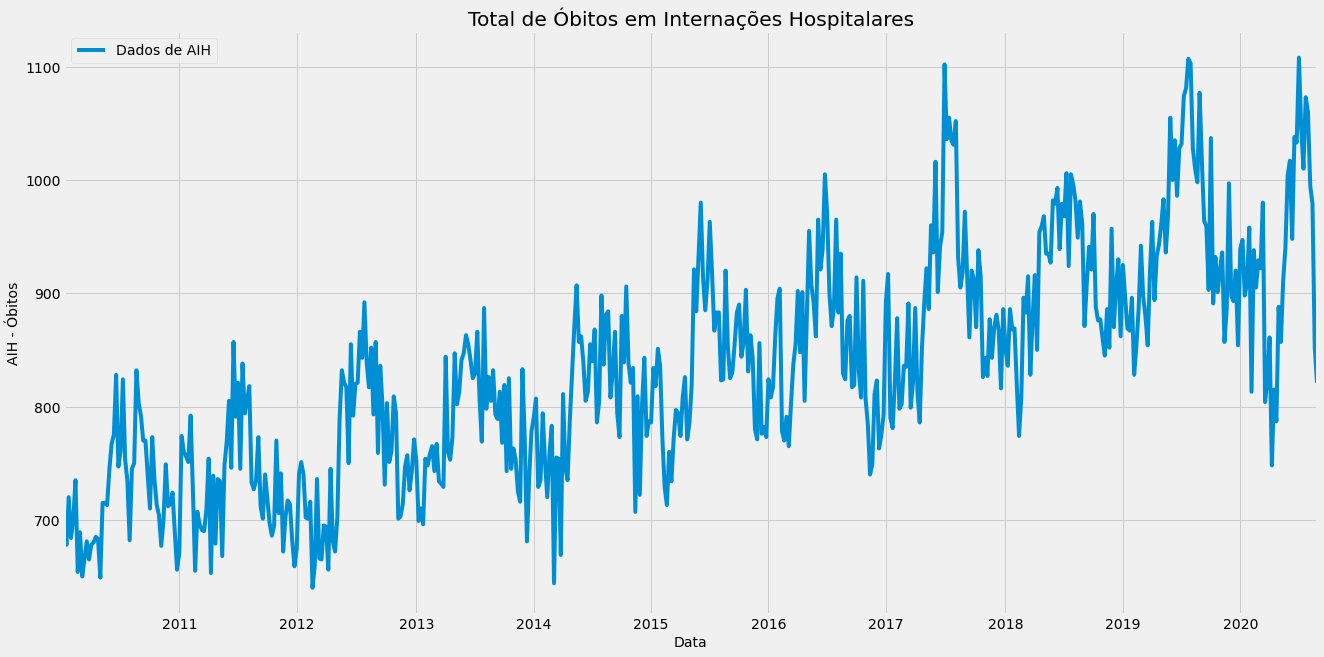

In [7]:
# Plot
target.plot(title = 'Total de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados de AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH - Óbitos") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [8]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

417 139


In [9]:
# Aplicando transformação de log
#treino_log = np.log(treino) 

In [10]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
#teste_log = np.log(teste)

In [11]:
# Teste ADF
ndiffs(target, test = 'adf') 

0

In [12]:
# Teste KPSS 
ndiffs(target, test = 'kpss')  

1

O Teste ADF indicou d = 0 e o Teste KPSS indicou d = 1.

A escolha é sua meu caro(a) Cientista de Dados.

In [13]:
# Função Para o Cálculo da Acurácia
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo ARIMA

Antes de criar o modelo ARIMA, vamos aplicar o conceito de Grid Search para encontrar a melhor combinação de valores para os parâmetros p, d e q.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

### Grid Search Para os Parâmetros p, d e q

In [14]:
# Avalia um modelo ARIMA
def avalia_modelo_arima(X, arima_order):
    
    # Prepara os dados
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # Previsões
    predictions = list()
    
    # Loop
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(method = 'mle', disp = 0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
      
    # Calcula o erro do modelo
    error = mean_squared_error(test, predictions)
    return error

In [15]:
# Avalia as combinações de valores p, d e q para um modelo ARIMA
def avalia_melhor_arima(dataset, p_values, d_values, q_values):
    
    # Ajusta o tipo dos dados
    dataset = dataset.astype('float32')
    
    # Define variáveis de controle
    best_score, best_cfg = float("inf"), None
    
    # Loop pelos valores de p, d e q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = avalia_modelo_arima(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s   MSE = %.4f   RMSE = %.4f'% (order, mse, np.sqrt(mse)))
                except:
                    continue

    print('\nMelhor Modelo ARIMA%s   MSE = %.4f   RMSE = %.4f' % (best_cfg, best_score, np.sqrt(best_score)))

In [18]:
# Valores para o grid
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1] 
q_values = [0, 1, 2, 3, 4, 5] 

In [19]:
# Testando o melhor valor de p, d e q em os dados de treino
warnings.simplefilter("ignore")

avalia_melhor_arima(treino.values, p_values, d_values, q_values)

ARIMA(0, 0, 0)   MSE = 13251.6663   RMSE = 115.1159
ARIMA(0, 0, 1)   MSE = 6867.0398   RMSE = 82.8676
ARIMA(0, 0, 2)   MSE = 5186.1362   RMSE = 72.0148
ARIMA(0, 0, 3)   MSE = 4827.4237   RMSE = 69.4797
ARIMA(0, 0, 4)   MSE = 4223.8931   RMSE = 64.9915
ARIMA(0, 0, 5)   MSE = 3758.1895   RMSE = 61.3041
ARIMA(0, 1, 0)   MSE = 3290.6955   RMSE = 57.3646
ARIMA(0, 1, 1)   MSE = 2757.5031   RMSE = 52.5119
ARIMA(0, 1, 2)   MSE = 2742.7632   RMSE = 52.3714
ARIMA(0, 1, 3)   MSE = 2740.9388   RMSE = 52.3540
ARIMA(0, 1, 4)   MSE = 2774.0722   RMSE = 52.6695
ARIMA(0, 1, 5)   MSE = 2778.1740   RMSE = 52.7084
ARIMA(1, 0, 0)   MSE = 3265.3136   RMSE = 57.1429
ARIMA(1, 0, 1)   MSE = 2778.2791   RMSE = 52.7094
ARIMA(1, 0, 2)   MSE = 2777.6373   RMSE = 52.7033
ARIMA(1, 0, 3)   MSE = 2772.8019   RMSE = 52.6574
ARIMA(1, 0, 4)   MSE = 2788.3518   RMSE = 52.8048
ARIMA(1, 0, 5)   MSE = 2800.1115   RMSE = 52.9161
ARIMA(1, 1, 0)   MSE = 3065.0897   RMSE = 55.3633
ARIMA(1, 1, 1)   MSE = 2745.9083   RMSE = 52.401

As mensagens de warning acima indicam que as algumas combinações testadas não fazem o modelo nem mesmo convergir.

De acordo com o resultado, os melhores valores são: order = (3,1,3). 

## Vamos fazer previsões com o modelo Forecast usando 'ARIMA'

In [20]:
# Modelo
modelo_AR = ARIMA(treino, order = (3, 1, 3))

In [21]:
# Treinamento
#modelo_v1 = modelo_AR.fit(disp = -1)  
modelo_v1 = modelo_AR.fit(method = 'mle', disp = False)

In [22]:
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.QT_INTER   No. Observations:                  416
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -2172.329
Method:                           mle   S.D. of innovations             44.791
Date:                Wed, 25 Nov 2020   AIC                           4360.659
Time:                        18:09:53   BIC                           4392.904
Sample:                    01-17-2010   HQIC                          4373.409
                         - 12-31-2017                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4172      0.917      0.455      0.649      -1.379       2.214
ar.L1.D.QT_INTER     0.6065      0.102      5.927      0.000       0.406       0.807
ar.L2.D.QT_INTER    -1.0034      0.064    -15.778      0.000      -1.128      -0.879
ar.L3.D.QT_INTER     0.1403      0.092      1.526      0.127      -0.040       0.321
ma.L1.D.QT_INTER    -1.1492      0.087    -13.261      0.000      -1.319      -0.979
ma.L2.D.QT_INTER     1.2798      0.090     14.170      0.000       1.103       1.457
ma.L3.D.QT_INTER    -0.6082      0.079     -7.714      0.000      -0.763      -0.454
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2441           -1.0050j            1.0343           -0.2121
AR.2            0.2441           +1.0050j            1.0343            0.2121
AR.3            6.6614           -0.0000j            6.6614           -0.0000
MA.1            0.2682           -0.9883j            1.0240           -0.2078
MA.2            0.2682           +0.9883j            1.0240            0.2078
MA.3            1.5681           -0.0000j            1.5681           -0.0000
-----------------------------------------------------------------------------
"""

In [23]:
# Forecast
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
fc, se, conf = modelo_v1.forecast(len(teste), alpha = 0.05) 

# Precisamos criar um dataframe para criar o Plot
fc_series = pd.Series(fc, index = teste.index)
limite_inferior = pd.Series(conf[:, 0], index = teste.index)
limite_superior = pd.Series(conf[:, 1], index = teste.index)

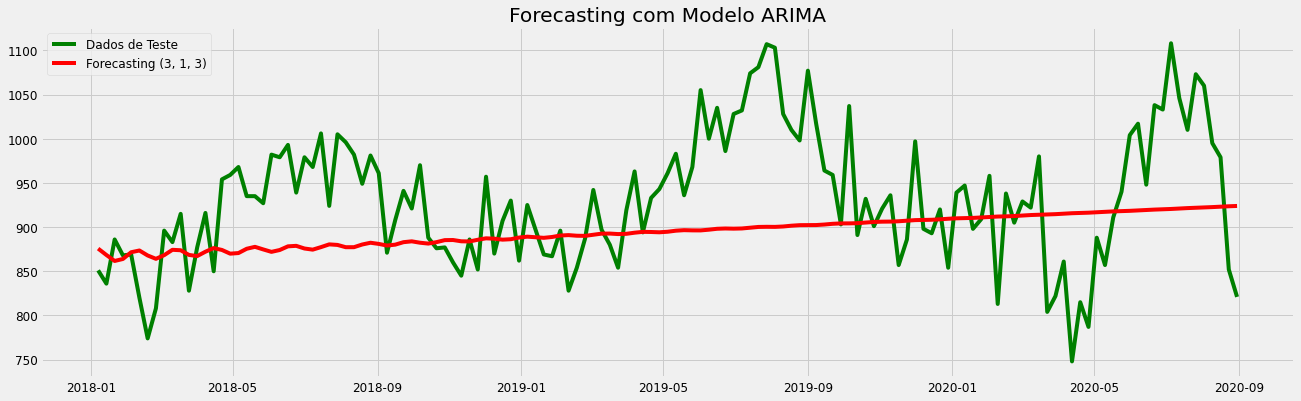

In [25]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting (3, 1, 3)', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [26]:
# Calculando a performance
arima_results = performance(teste, fc_series)
#arima_results

MSE das previsões é 6471.9802
RMSE das previsões é 80.4486
MAPE das previsões é 6.6372


## Vamos fazer previsões com o modelo usando 'ARIMA'

In [27]:
# Cria o modelo com os dados de treino
modelo_arima = ARIMA(treino, order = (3,1,3))

In [28]:
# Treina o modelo
#modelo_arima_fit = modelo_arima.fit(disp = -1)  
modelo_arima_fit = modelo_arima.fit(method = 'mle', disp = False)

In [29]:
# Sumário do modelo
modelo_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.QT_INTER   No. Observations:                  416
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -2172.329
Method:                           mle   S.D. of innovations             44.791
Date:                Wed, 25 Nov 2020   AIC                           4360.659
Time:                        18:12:13   BIC                           4392.904
Sample:                    01-17-2010   HQIC                          4373.409
                         - 12-31-2017                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4172      0.917      0.455      0.649      -1.379       2.214
ar.L1.D.QT_INTER     0.6065      0.102      5.927      0.000       0.406       0.807
ar.L2.D.QT_INTER    -1.0034      0.064    -15.778      0.000      -1.128      -0.879
ar.L3.D.QT_INTER     0.1403      0.092      1.526      0.127      -0.040       0.321
ma.L1.D.QT_INTER    -1.1492      0.087    -13.261      0.000      -1.319      -0.979
ma.L2.D.QT_INTER     1.2798      0.090     14.170      0.000       1.103       1.457
ma.L3.D.QT_INTER    -0.6082      0.079     -7.714      0.000      -0.763      -0.454
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2441           -1.0050j            1.0343           -0.2121
AR.2            0.2441           +1.0050j            1.0343            0.2121
AR.3            6.6614           -0.0000j            6.6614           -0.0000
MA.1            0.2682           -0.9883j            1.0240           -0.2078
MA.2            0.2682           +0.9883j            1.0240            0.2078
MA.3            1.5681           -0.0000j            1.5681           -0.0000
-----------------------------------------------------------------------------
"""

> Observe a métrica AIC (Akaike Information Criterion). Esse valor deve ser o menor possível para uma boa performance do modelo.

## Previsão com o modelo treinado - Predict

In [30]:
# Predict
# Previsões com o modelo (passamos somente as datas e o modelo prevê os valores)
arima_predict = modelo_arima_fit.predict(start = pd.to_datetime('2018-01-01'), 
                                         end = pd.to_datetime('2020-09-01'),
                                         dynamic = False)

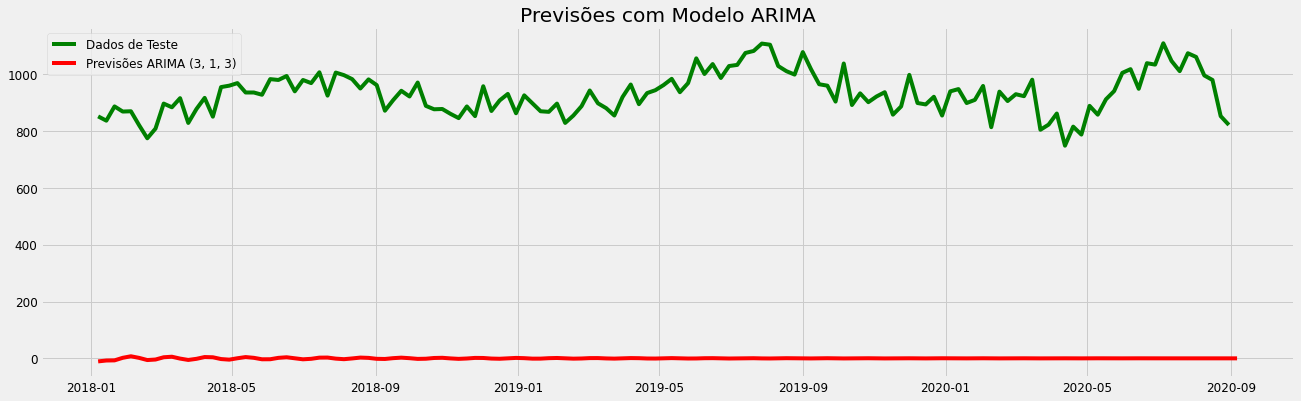

In [33]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (3, 1, 3)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

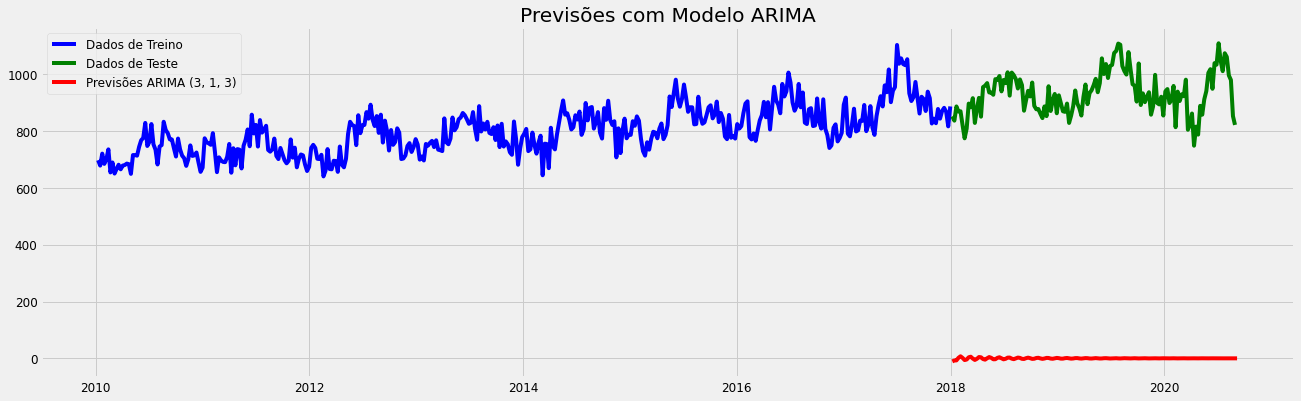

In [35]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino, label = 'Dados de Treino', color = 'blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (3, 1, 3)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [36]:
# Calculando a performance
arima_results = performance(teste, arima_predict)
#arima_results

MSE das previsões é 872158.9377
RMSE das previsões é 933.8945
MAPE das previsões é 99.9729


Vamos executar alguns diagnósticos para avaliar o modelo.

> Os resíduos do modelo devem ser normalmente distribuídos. Vamos checar com o teste jarque_bera.

In [37]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.51970398  -  Os resíduos parecem normalmente distribuídos.


In [38]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arima_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.27275733]


Observe que o valor-p é menor que 0,05, o que indica que os resíduos não são independentes no nível de 95% e, portanto, um modelo ARIMA (2,0,1) não fornece um bom ajuste do modelo.

Como estamos até agora:

- Modelo 15 --> Modelo ARMA (12,9) - AIC = 4359.931 e RMSE = 100,0858
- Modelo 16 --> Modelo ARIMA Forcast (3,1,3) Forecast - AIC = 4360.659 e RMSE = 80.4486

Com o modelo ARIMA conseguimos reduzir o erro total do modelo, embora o AIC tenha aumentado um pouco. O ARIMA Predict não convergiu.

O modelo ARIMA consegue um ajuste aos dados, mas é muito pior que o modelo ARMA.

Vamos ver o que conseguimos com um modelo mais avançado, o SARIMA. Na próxima aula. 

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim